In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

# Charger les données d'entraînement et de test
with open('../nlpDataSet/train.json', 'r') as f:
    train_data = json.load(f)

with open('../nlpDataSet/test.json', 'r') as f:
    test_data = json.load(f)

In [8]:
# Préparer les données
def preprocess_data(data):
    sentences = []
    labels = []
    label_map = {
        "O": 0,
        "VILLE_DEPART": 1,
        "I-VILLE_DEPART": 2,
        "VILLE_DESTINATION": 3,
        "I-VILLE_DESTINATION": 4
    }

    for item in data:
        text = item['sentence']
        entities = item['entities']
        label_seq = ["O"] * len(text)

        for ent in entities:
            start, end, label = ent['start'], ent['end'], ent['label']
            label_seq[start] = label
            for i in range(start + 1, end):
                label_seq[i] = f"I-{label}"

        sentences.append(text)
        labels.append([label_map[label] for label in label_seq])

    return sentences, labels

train_sentences, train_labels = preprocess_data(train_data)
test_sentences, test_labels = preprocess_data(test_data)

# Vérifier la distribution des étiquettes
def check_label_distribution(labels):
    all_labels = [label for example in labels for label in example]
    label_counts = Counter(all_labels)
    print("Répartition des étiquettes :", label_counts)

check_label_distribution(train_labels)
check_label_distribution(test_labels)


Répartition des étiquettes : Counter({0: 90096, 2: 8591, 4: 8425, 1: 807, 3: 807})
Répartition des étiquettes : Counter({0: 22672, 2: 2024, 4: 2005, 1: 193, 3: 193})


In [9]:
# Charger le tokenizer et le modèle
model_name = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizer les données
def tokenize_and_align_labels(sentences, labels):
    tokenized_inputs = tokenizer(sentences, truncation=True, padding=True, is_split_into_words=False)
    aligned_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorer ce token
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # Ignorer les sous-tokens

            previous_word_idx = word_idx
        aligned_labels.append(label_ids)

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

train_dataset = Dataset.from_dict(tokenize_and_align_labels(train_sentences, train_labels))
test_dataset = Dataset.from_dict(tokenize_and_align_labels(test_sentences, test_labels))

datasets = DatasetDict({"train": train_dataset, "test": test_dataset})


In [10]:
# Charger le modèle avec le bon nombre d'étiquettes
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=5)

# Configurer l'entraînement
args = TrainingArguments(
    output_dir="bert-ner",
    evaluation_strategy="epoch",  # Remplace evaluation_strategy (obsolète)
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    save_total_limit=2,
)

data_collator = DataCollatorForTokenClassification(tokenizer)

# Fonction de métrique corrigée
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[label for label in example if label != -100] for example in labels]
    true_predictions = [[pred for (pred, label) in zip(prediction, example) if label != -100]
                        for prediction, example in zip(predictions, labels)]

    y_true = [label for example in true_labels for label in example]
    y_pred = [pred for example in true_predictions for pred in example]

    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)

    return {"f1": f1, "precision": precision, "recall": recall}


Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/pacomedhiser/Documents/epitech/T-AIA-901-NAN_2/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# Entraîner le modèle
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.363400,0.358030,0.931991,0.956393,0.954305
2,0.250700,0.224979,0.980315,0.987309,0.985651
3,0.182800,0.174442,0.991092,0.991483,0.991611
4,0.176500,0.152401,0.994195,0.994154,0.994260
5,0.146400,0.146009,0.994195,0.994154,0.994260


TrainOutput(global_step=500, training_loss=0.31738940501213075, metrics={'train_runtime': 265.072, 'train_samples_per_second': 30.18, 'train_steps_per_second': 1.886, 'total_flos': 151066284720000.0, 'train_loss': 0.31738940501213075, 'epoch': 5.0})

TrainOutput(global_step=500, training_loss=0.2732455098628998, metrics={'train_runtime': 265.169, 'train_samples_per_second': 30.169, 'train_steps_per_second': 1.886, 'total_flos': 151066284720000.0, 'train_loss': 0.2732455098628998, 'epoch': 5.0})

{'eval_loss': 0.14600926637649536, 'eval_f1': 0.9941953381133425, 'eval_precision': 0.9941542925320831, 'eval_recall': 0.9942604856512142, 'eval_runtime': 3.1363, 'eval_samples_per_second': 127.541, 'eval_steps_per_second': 15.943, 'epoch': 5.0}


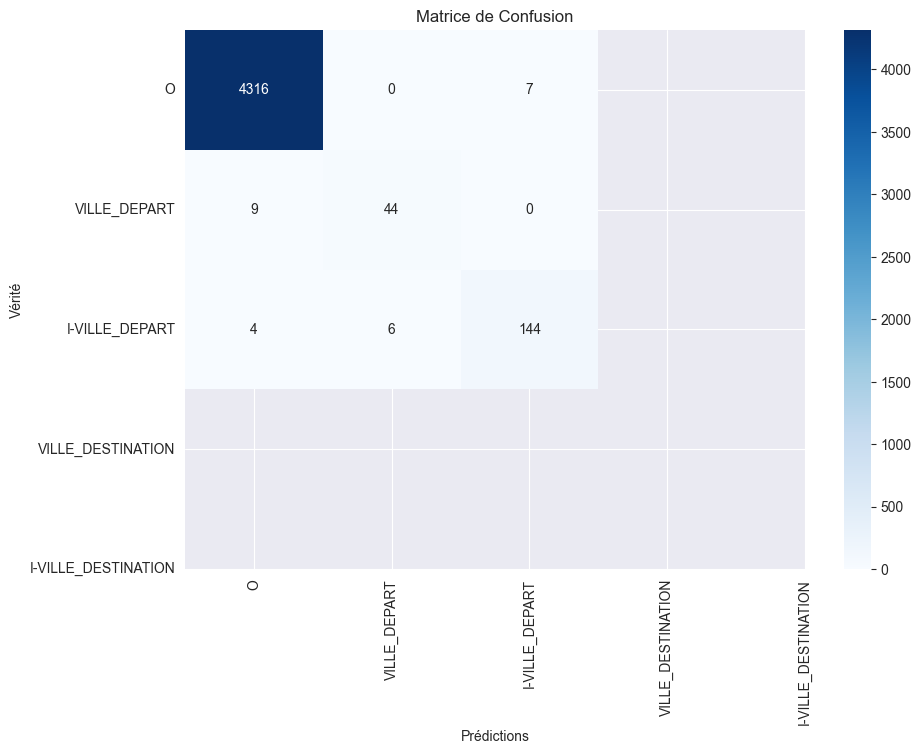

In [18]:
# Évaluation
metrics = trainer.evaluate()
print(metrics)

# Visualisation de la matrice de confusion
def align_predictions(predictions, labels):
    true_labels = []
    true_predictions = []
    for prediction, label in zip(predictions, labels):
        for pred, lab in zip(prediction, label):
            if lab != -100:
                true_labels.append(lab)
                true_predictions.append(pred)
    return true_labels, true_predictions

predictions = trainer.predict(datasets["test"]).predictions
y_pred = np.argmax(predictions, axis=2)
y_true, y_pred = align_predictions(y_pred, datasets["test"]["labels"])

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["O", "VILLE_DEPART", "I-VILLE_DEPART", "VILLE_DESTINATION", "I-VILLE_DESTINATION"],
    yticklabels=["O", "VILLE_DEPART", "I-VILLE_DEPART", "VILLE_DESTINATION", "I-VILLE_DESTINATION"]
)
plt.xlabel("Prédictions")
plt.ylabel("Vérité")
plt.title("Matrice de Confusion")
plt.show()
